In [1]:
import os
import sys
import json
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import datetime
from matplotlib import pyplot as plt
from IPython.display import display, Markdown
import sweetviz
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../utils')
from common_utils import fast_plot, fast_hist, fast_legend, feature_snapshot, fast_scatter, fast_bar, fast_barh

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)

# Загрузка данных

In [3]:
target_train = pd.read_csv('data/raw/target_train.csv', index_col='NPLV')
chugun_train  = pd.read_csv('data/raw/chugun_train.csv', index_col='NPLV')
plavki_train = pd.read_csv('data/raw/plavki_train.csv', index_col='NPLV')

sample_submission = pd.read_csv('data/raw/sample_submission.csv', index_col='NPLV')
chugun_test  = pd.read_csv('data/raw/chugun_test.csv', index_col='NPLV')
plavki_test = pd.read_csv('data/raw/plavki_test.csv', index_col='NPLV')

In [4]:
print('target_train', target_train.shape)
print('chugun_train', chugun_train.shape)
print('plavki_train', plavki_train.shape)
print('sample_submission', sample_submission.shape)
print('chugun_test', chugun_test.shape)
print('plavki_test', plavki_test.shape)

target_train (2063, 2)
chugun_train (2063, 12)
plavki_train (2137, 9)
sample_submission (780, 2)
chugun_test (780, 12)
plavki_test (780, 9)


In [5]:
%%time
sip_train = pd.read_csv('data/raw/sip_train.csv')
sip_test = pd.read_csv('data/raw/sip_test.csv')

chronom_train = pd.read_csv('data/raw/chronom_train.csv', index_col=0, parse_dates=['VR_NACH', 'VR_KON'])
chronom_test = pd.read_csv('data/raw/chronom_test.csv', index_col=0, parse_dates=['VR_NACH', 'VR_KON'])

lom_train = pd.read_csv('data/raw/lom_train.csv')
lom_test = pd.read_csv('data/raw/lom_test.csv')

produv_train = pd.read_csv('data/raw/produv_train.csv')
produv_test = pd.read_csv('data/raw/produv_test.csv')

gas_train = pd.read_csv('data/raw/gas_train.csv')
gas_test = pd.read_csv('data/raw/gas_test.csv')

Wall time: 21.5 s


In [6]:
print('sip_train', sip_train.shape)
print('sip_test', sip_test.shape)
print('chronom_train', chronom_train.shape)
print('chronom_test', chronom_test.shape)
print('lom_train', lom_train.shape)
print('lom_test', lom_test.shape)
print('produv_train', produv_train.shape)
print('produv_test', produv_test.shape)
print('gas_train', gas_train.shape)
print('gas_test', gas_test.shape)

sip_train (31584, 5)
sip_test (10462, 5)
chronom_train (34406, 6)
chronom_test (7845, 6)
lom_train (6376, 4)
lom_test (2632, 4)
produv_train (4729802, 4)
produv_test (1692377, 4)
gas_train (6468018, 13)
gas_test (2515868, 13)


## Fix plavki_train

In [7]:
plavki_train.index.to_series().value_counts()

511135    75
510008     1
511544     1
511558     1
511557     1
          ..
510773     1
510772     1
510771     1
510770     1
512322     1
Name: NPLV, Length: 2063, dtype: int64

In [8]:
plavki_train[plavki_train.index == 511135].tail(3)

,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
NPLV,,,,,,,,,
511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,44,5 сопловая,44
511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,45,5 сопловая,45
511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,46,5 сопловая,46


In [9]:
plavki_train[plavki_train['plavka_VR_KON'] < '2021-02-27 20:27:36'].tail(3)

,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
NPLV,,,,,,,,,
511128,2021-02-27 10:25:34,2021-02-27 11:13:21,C071TM.z01/ЭТ,МНЛС,2091,цилиндрическая,56,5 сопловая,154
511130,2021-02-27 12:52:30,2021-02-27 13:44:00,С255,МНЛЗ,2093,цилиндрическая,58,5 сопловая,156
511131,2021-02-27 13:48:53,2021-02-27 15:16:38,СТ3ГСП.2,Изл,2094,цилиндрическая,59,5 сопловая,157


In [10]:
plavki_train[plavki_train['plavka_VR_NACH'] > '2021-02-27 21:28:44'].head(3)

,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
NPLV,,,,,,,,,
511137,2021-02-27 22:58:49,2021-02-27 23:56:37,C071TM.z01/ЭТ,МНЛС,2100,цилиндрическая,48,5 сопловая,48
511139,2021-02-28 01:38:56,2021-02-28 02:57:53,C071TM.z01/ЭТ,МНЛС,2102,цилиндрическая,50,5 сопловая,50
511140,2021-02-28 03:02:00,2021-02-28 04:24:29,C071TM.z01/ЭТ,МНЛС,2103,цилиндрическая,51,5 сопловая,51


In [11]:
mask = (plavki_train.index == 511135) & (plavki_train['plavka_ST_FURM'] != 46)
mask.sum()

74

In [12]:
plavki_train = plavki_train[~mask]
plavki_train

,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
NPLV,,,,,,,,,
510008,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
510009,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
510010,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13
510011,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14
510012,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15
...,...,...,...,...,...,...,...,...,...
512318,2021-04-26 13:04:26,2021-04-26 13:55:50,C071TM.z01/ЭТ,МНЛС,3281,коническая,22,5 сопловая,56
512319,2021-04-26 14:10:20,2021-04-26 15:14:23,C071TM.z01/ЭТ,МНЛС,3282,коническая,23,5 сопловая,57
512320,2021-04-26 15:21:37,2021-04-26 16:16:42,40Х.1,МНЛЗ,3283,коническая,24,5 сопловая,58


## lom

In [28]:
lom_train = pd.read_csv('data/raw/lom_train.csv')
lom_test = pd.read_csv('data/raw/lom_test.csv')

In [29]:
lom_train

,NPLV,VDL,NML,VES
0,510008,4,К,56500
1,510008,8,О,16700
2,510008,13,КП,3000
3,510009,4,К,49800
4,510009,8,О,22800
...,...,...,...,...
6371,512321,8,О,4200
6372,512321,13,КП,3000
6373,512322,4,К,66700
6374,512322,13,КП,6000


In [30]:
lom_train.nunique()

NPLV    2063
VDL       10
NML       10
VES      866
dtype: int64

In [31]:
pd.crosstab(lom_train['VDL'], lom_train['NML'])

NML,25КШ,К,КП,КШС8,ЛЧ,НБ,О,ОК,СК,У2КШ
VDL,,,,,,,,,,
3,0,0,0,0,0,1,0,0,0,0
4,0,2056,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1273,0,0,0
13,0,0,1826,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,107,0,0
23,0,0,0,0,463,0,0,0,0,0
48,0,0,0,0,0,0,0,0,0,133
49,258,0,0,0,0,0,0,0,0,0
61,0,0,0,254,0,0,0,0,0,0


In [32]:
lom_train = lom_train.drop(columns='NML')
lom_test = lom_test.drop(columns='NML')

In [33]:
lom_train = pd.pivot(lom_train, index='NPLV', columns='VDL', values='VES').fillna(0).astype(int).add_prefix('lom_VES_VLD')
lom_test = pd.pivot(lom_test, index='NPLV', columns='VDL', values='VES').fillna(0).astype(int).add_prefix('lom_VES_VLD')

lom_train['lom_components'] = lom_train.apply(lambda x: (x > 0).sum(), axis=1)
lom_test['lom_components'] = lom_test.apply(lambda x: (x > 0).sum(), axis=1)

lom_train

VDL,lom_VES_VLD3,lom_VES_VLD4,lom_VES_VLD8,lom_VES_VLD13,lom_VES_VLD20,lom_VES_VLD23,lom_VES_VLD48,lom_VES_VLD49,lom_VES_VLD61,lom_VES_VLD63,lom_components
NPLV,,,,,,,,,,,
510008,0,56500,16700,3000,0,0,0,0,0,0,3
510009,0,49800,22800,6000,0,0,0,0,0,0,3
510010,0,45900,22400,2000,0,6000,0,0,0,0,4
510011,0,51900,29200,3000,0,0,0,0,0,0,3
510012,0,64000,6100,6000,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
512318,0,51700,3300,3000,0,11500,4100,0,0,0,5
512319,0,46400,15300,5000,0,9900,0,0,0,0,4
512320,0,41400,0,5000,0,0,17800,0,0,0,3


In [34]:
lom_test

VDL,lom_VES_VLD4,lom_VES_VLD8,lom_VES_VLD13,lom_VES_VLD20,lom_VES_VLD23,lom_VES_VLD48,lom_VES_VLD49,lom_VES_VLD61,lom_VES_VLD63,lom_components
NPLV,,,,,,,,,,
512324,26040,17660,2000,0,0,0,0,0,0,3
512327,49400,10600,3000,0,8000,0,0,0,0,4
512328,65700,0,6000,0,0,0,0,0,0,2
512331,36000,32500,2000,0,0,0,0,0,0,3
512333,40300,62200,2000,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
513369,52700,2300,6000,0,0,0,0,0,0,3
513370,52700,0,3000,0,0,6600,0,0,0,3
513371,60100,0,6000,0,2000,0,0,0,0,3


In [35]:
# remove 1 column
lom_train = lom_train[lom_test.columns]

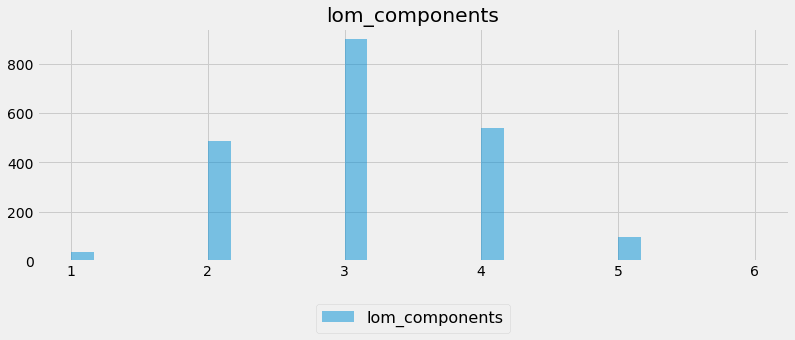

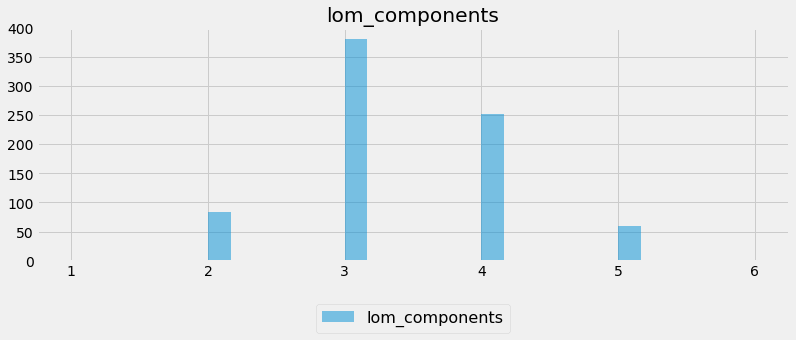

In [36]:
fast_hist(lom_train['lom_components'])
fast_hist(lom_test['lom_components'])

In [37]:
lom_train

VDL,lom_VES_VLD4,lom_VES_VLD8,lom_VES_VLD13,lom_VES_VLD20,lom_VES_VLD23,lom_VES_VLD48,lom_VES_VLD49,lom_VES_VLD61,lom_VES_VLD63,lom_components
NPLV,,,,,,,,,,
510008,56500,16700,3000,0,0,0,0,0,0,3
510009,49800,22800,6000,0,0,0,0,0,0,3
510010,45900,22400,2000,0,6000,0,0,0,0,4
510011,51900,29200,3000,0,0,0,0,0,0,3
510012,64000,6100,6000,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
512318,51700,3300,3000,0,11500,4100,0,0,0,5
512319,46400,15300,5000,0,9900,0,0,0,0,4
512320,41400,0,5000,0,0,17800,0,0,0,3


## sip_train
* Удалил дату отгрузки
* Удалил сыпучие, которых не было в трейне

In [38]:
sip_test.nunique()

NPLV        780
VDSYP         9
NMSYP         8
VSSYP       643
DAT_OTD    9494
dtype: int64

In [39]:
sip_train.nunique()

NPLV        2063
VDSYP          7
NMSYP          6
VSSYP        845
DAT_OTD    28314
dtype: int64

In [40]:
sip_train['NPLV'].value_counts()

511827    43
511232    39
510200    34
510032    34
510201    32
          ..
512051     3
512129     3
512157     3
512212     3
512223     3
Name: NPLV, Length: 2063, dtype: int64

In [41]:
sip_train

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20
...,...,...,...,...,...
31579,512322,408,изв_ЦОИ,30,2021-04-26 18:28:06
31580,512322,408,изв_ЦОИ,490,2021-04-26 18:28:07
31581,512322,408,изв_ЦОИ,20,2021-04-26 18:28:22
31582,512322,408,изв_ЦОИ,970,2021-04-26 18:30:26


In [42]:
pd.crosstab(sip_train['VDSYP'], sip_train['NMSYP'])

NMSYP,Долом(сыр),Уголь ТО,ФЛЮМАГ,Флюс ФОМИ,изв отсев,изв_ЦОИ
VDSYP,,,,,,
104,0,0,0,0,226,0
119,2,0,0,0,0,0
171,0,0,0,1624,0,0
346,0,7583,0,0,0,0
397,0,164,0,0,0,0
408,0,0,0,0,0,19055
442,0,0,2930,0,0,0


In [43]:
pd.crosstab(sip_test['VDSYP'], sip_test['NMSYP'])

NMSYP,Уголь ТО,ФЛЮМАГ,Флюс ФОМИ,агл_офл_с,долом_сыр,изв_ЦОИ,изв_отсев,кокс_25_40
VDSYP,,,,,,,,
11,0,0,0,0,0,0,0,7
104,0,0,0,0,0,0,204,0
119,0,0,0,0,147,0,0,0
171,0,0,341,0,0,0,0,0
344,0,0,0,154,0,0,0,0
346,904,0,0,0,0,0,0,0
397,145,0,0,0,0,0,0,0
408,0,0,0,0,0,7718,0,0
442,0,842,0,0,0,0,0,0


In [44]:
sip_train = sip_train.drop(columns=['NMSYP', 'DAT_OTD'])
sip_test = sip_test.drop(columns=['NMSYP', 'DAT_OTD'])

In [46]:
sip_train = sip_train.groupby(['NPLV', 'VDSYP'])['VSSYP'].sum().reset_index()
sip_test = sip_test.groupby(['NPLV', 'VDSYP'])['VSSYP'].sum().reset_index()

In [47]:
sip_train

,NPLV,VDSYP,VSSYP
0,510008,171,980
1,510008,346,2950
2,510008,408,14080
3,510008,442,2960
4,510009,104,1060
...,...,...,...
6905,512321,346,520
6906,512321,408,16100
6907,512321,442,2310
6908,512322,408,21150


In [48]:
sip_train = pd.pivot(sip_train, index='NPLV', columns='VDSYP', values='VSSYP').fillna(0).astype(int).add_prefix('sip_VES_VDSYP')
sip_test = pd.pivot(sip_test, index='NPLV', columns='VDSYP', values='VSSYP').fillna(0).astype(int).add_prefix('sip_VES_VDSYP')

sip_test

VDSYP,sip_VES_VDSYP11,sip_VES_VDSYP104,sip_VES_VDSYP119,sip_VES_VDSYP171,sip_VES_VDSYP344,sip_VES_VDSYP346,sip_VES_VDSYP397,sip_VES_VDSYP408,sip_VES_VDSYP442
NPLV,,,,,,,,,
512324,0,0,0,0,0,1310,0,13960,1670
512327,50,0,0,0,0,0,0,15290,0
512328,1400,0,0,0,0,0,0,20010,0
512331,930,0,0,0,0,0,0,14060,0
512333,960,0,0,0,0,0,0,20100,0
...,...,...,...,...,...,...,...,...,...
513369,0,0,0,0,0,2010,0,13990,2980
513370,0,0,0,0,0,2190,0,14030,2750
513371,0,0,0,0,0,2030,0,12380,2920


In [49]:
# Remove columns

sip_test = sip_test[sip_train.columns]
sip_test

VDSYP,sip_VES_VDSYP104,sip_VES_VDSYP119,sip_VES_VDSYP171,sip_VES_VDSYP346,sip_VES_VDSYP397,sip_VES_VDSYP408,sip_VES_VDSYP442
NPLV,,,,,,,
512324,0,0,0,1310,0,13960,1670
512327,0,0,0,0,0,15290,0
512328,0,0,0,0,0,20010,0
512331,0,0,0,0,0,14060,0
512333,0,0,0,0,0,20100,0
...,...,...,...,...,...,...,...
513369,0,0,0,2010,0,13990,2980
513370,0,0,0,2190,0,14030,2750
513371,0,0,0,2030,0,12380,2920


In [51]:
sip_train

VDSYP,sip_VES_VDSYP104,sip_VES_VDSYP119,sip_VES_VDSYP171,sip_VES_VDSYP346,sip_VES_VDSYP397,sip_VES_VDSYP408,sip_VES_VDSYP442
NPLV,,,,,,,
510008,0,0,980,2950,0,14080,2960
510009,1060,0,960,2930,0,18830,0
510010,990,0,1050,2990,0,16080,2960
510011,550,0,980,3620,0,22150,0
510012,2050,0,1000,2930,0,19550,3010
...,...,...,...,...,...,...,...
512318,0,0,0,0,0,14640,2890
512319,0,0,0,960,0,19210,2820
512320,0,0,0,1380,0,19420,2830


In [52]:
sip_train['sip_components'] = sip_train.apply(lambda x: (x > 0).sum(), axis=1)
sip_test['sip_components'] = sip_test.apply(lambda x: (x > 0).sum(), axis=1)

sip_train

VDSYP,sip_VES_VDSYP104,sip_VES_VDSYP119,sip_VES_VDSYP171,sip_VES_VDSYP346,sip_VES_VDSYP397,sip_VES_VDSYP408,sip_VES_VDSYP442,sip_components
NPLV,,,,,,,,
510008,0,0,980,2950,0,14080,2960,4
510009,1060,0,960,2930,0,18830,0,4
510010,990,0,1050,2990,0,16080,2960,5
510011,550,0,980,3620,0,22150,0,4
510012,2050,0,1000,2930,0,19550,3010,5
...,...,...,...,...,...,...,...,...
512318,0,0,0,0,0,14640,2890,2
512319,0,0,0,960,0,19210,2820,3
512320,0,0,0,1380,0,19420,2830,3


## produv_train

In [53]:
produv_train

,NPLV,SEC,RAS,POL
0,510008,2021-01-01 03:18:26,382.000000,3.920000
1,510008,2021-01-01 03:18:28,382.000000,3.920000
2,510008,2021-01-01 03:18:30,553.000000,3.920000
3,510008,2021-01-01 03:18:32,701.000000,3.920000
4,510008,2021-01-01 03:18:34,813.000000,3.920000
...,...,...,...,...
4729797,512322,2021-05-05 16:30:46,363.996249,4.850045
4729798,512322,2021-05-05 16:30:48,363.996999,4.850036
4729799,512322,2021-05-05 16:30:50,363.997749,4.850027
4729800,512322,2021-05-05 16:30:52,363.998499,4.850018


In [54]:
produv_train['NPLV'].value_counts()

512322    385864
510437     20825
510167     19369
511929     18236
510294     18065
           ...  
512063      1165
512060      1155
512229      1109
512227      1058
510189       912
Name: NPLV, Length: 2063, dtype: int64

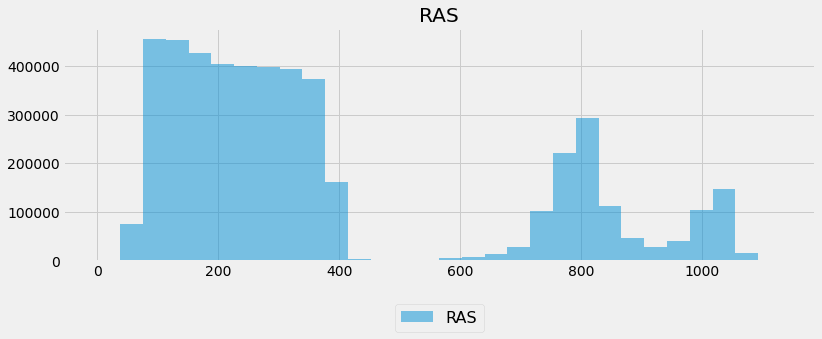

In [55]:
fast_hist(produv_train['RAS'])

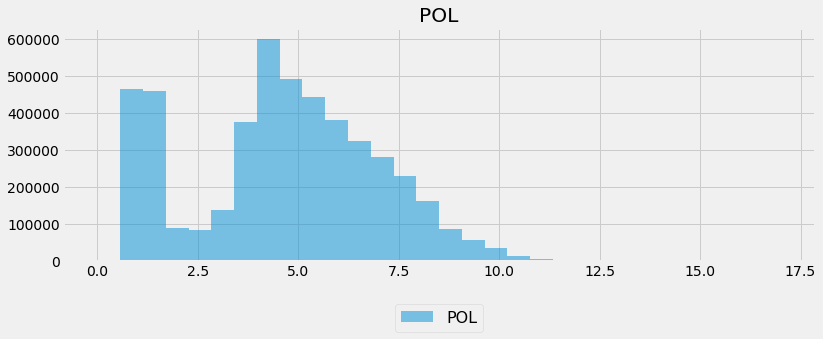

In [56]:
fast_hist(produv_train['POL'])

In [57]:
produv_train

,NPLV,SEC,RAS,POL
0,510008,2021-01-01 03:18:26,382.000000,3.920000
1,510008,2021-01-01 03:18:28,382.000000,3.920000
2,510008,2021-01-01 03:18:30,553.000000,3.920000
3,510008,2021-01-01 03:18:32,701.000000,3.920000
4,510008,2021-01-01 03:18:34,813.000000,3.920000
...,...,...,...,...
4729797,512322,2021-05-05 16:30:46,363.996249,4.850045
4729798,512322,2021-05-05 16:30:48,363.996999,4.850036
4729799,512322,2021-05-05 16:30:50,363.997749,4.850027
4729800,512322,2021-05-05 16:30:52,363.998499,4.850018


In [58]:
min_pol_train = produv_train.groupby('NPLV')['POL'].min().to_frame().add_prefix('produv_min_')
mean_pol_train = produv_train.groupby('NPLV')['POL'].mean().to_frame().add_prefix('produv_mean_')
max_pol_train = produv_train.groupby('NPLV')['POL'].max().to_frame().add_prefix('produv_max_')

min_pol_test = produv_test.groupby('NPLV')['POL'].min().to_frame().add_prefix('produv_min_')
mean_pol_test = produv_test.groupby('NPLV')['POL'].mean().to_frame().add_prefix('produv_mean_')
max_pol_test = produv_test.groupby('NPLV')['POL'].max().to_frame().add_prefix('produv_max_')

ras_train = produv_train.groupby('NPLV')['RAS'].sum().to_frame().add_prefix('produv_sum_')
ras_test = produv_test.groupby('NPLV')['RAS'].sum().to_frame().add_prefix('produv_sum_')

ras_train_mean = produv_train.groupby('NPLV')['RAS'].mean().to_frame().add_prefix('produv_mean_')
ras_test_mean = produv_test.groupby('NPLV')['RAS'].mean().to_frame().add_prefix('produv_mean_')

In [59]:
produv_train_groupped = pd.concat([max_pol_train, mean_pol_train, min_pol_train, ras_train_mean, ras_train], axis=1)
produv_test_groupped = pd.concat([max_pol_test, mean_pol_test, min_pol_test, ras_test_mean, ras_test], axis=1)

In [60]:
produv_train_groupped

,produv_max_POL,produv_mean_POL,produv_min_POL,produv_mean_RAS,produv_sum_RAS
NPLV,,,,,
510008,7.070000,4.116603,0.77,408.181995,838814.0
510009,4.760000,3.223137,0.63,437.750429,764750.0
510010,4.349765,3.188833,0.65,433.941227,764170.5
510011,12.490000,6.287681,0.79,392.992501,733717.0
510012,5.000000,3.717656,0.67,396.448585,840471.0
...,...,...,...,...,...
512318,10.100000,5.181084,0.80,372.911585,978520.0
512319,10.040000,4.778945,0.83,449.224197,783447.0
512320,7.270000,3.866538,0.90,410.935288,742971.0


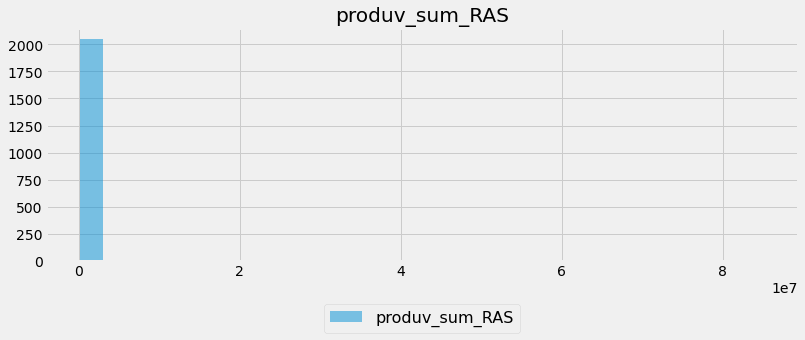

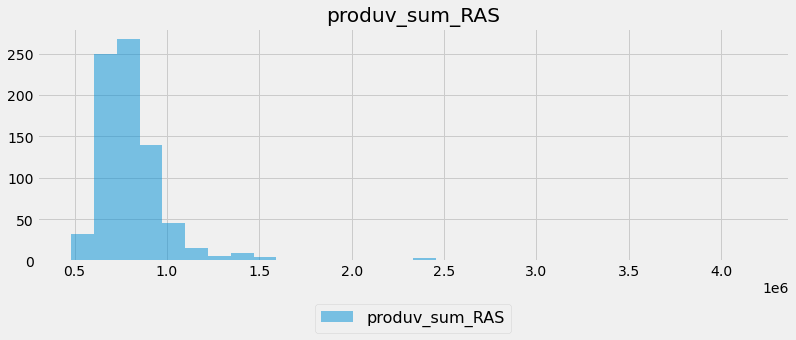

In [61]:
fast_hist(produv_train_groupped['produv_sum_RAS'])
fast_hist(produv_test_groupped['produv_sum_RAS'])

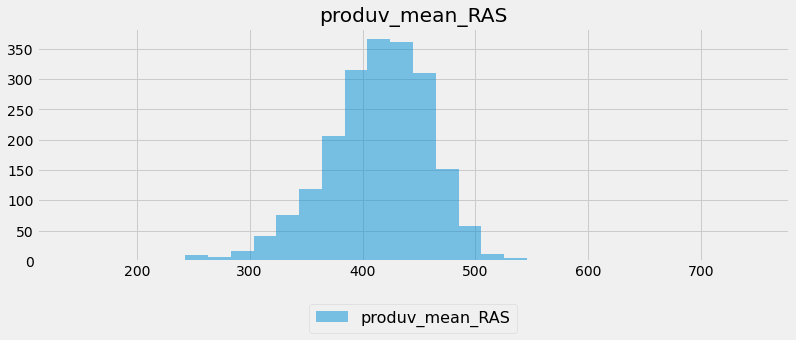

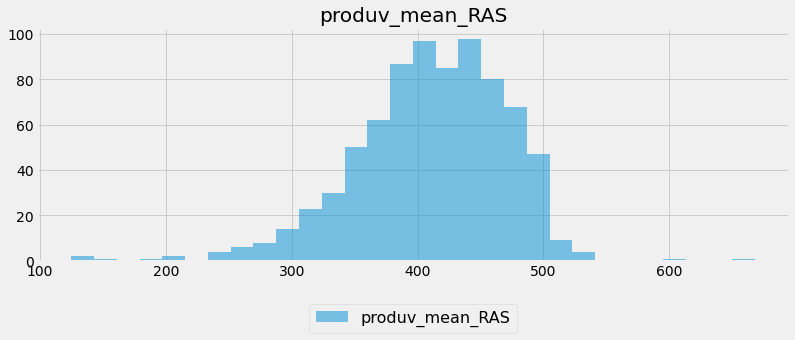

In [62]:
fast_hist(produv_train_groupped['produv_mean_RAS'])
fast_hist(produv_test_groupped['produv_mean_RAS'])

## gas_train
* Можно считать в долях, можно в объеме

In [63]:
print('gas_train', gas_train.shape)
print('gas_test', gas_test.shape)

gas_train (6468018, 13)
gas_test (2515868, 13)


In [64]:
produv_train['NPLV'].value_counts()

512322    385864
510437     20825
510167     19369
511929     18236
510294     18065
           ...  
512063      1165
512060      1155
512229      1109
512227      1058
510189       912
Name: NPLV, Length: 2063, dtype: int64

In [65]:
gas_train.nunique()

NPLV              2063
Time           6468018
V                 1028
T               202038
O2              778888
N2              543449
H2              264054
CO2             526595
CO              502869
AR              417319
T фурмы 1      2822312
T фурмы 2      1517076
O2_pressure     112048
dtype: int64

In [66]:
gas_train

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,9.229025e-03,0.893243,0.000000,0.000000,13.085938
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,8.390023e-03,0.892948,0.000000,0.000000,13.085938
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,7.551021e-03,0.892653,0.000000,0.000000,13.085938
3,510008,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,6.712018e-03,0.892358,0.000000,0.000000,13.093172
4,510008,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,5.873016e-03,0.892063,0.000000,0.000000,13.093172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6468013,512322,2021-04-26 18:48:35.437,207386.734375,118.402779,1.890000,97.220001,0.090000,0.050000,0.000000e+00,0.750000,23.900463,27.054343,14.424190
6468014,512322,2021-04-26 18:48:36.437,207051.609375,118.402779,2.710000,96.410004,0.080000,0.040000,0.000000e+00,0.770000,23.900463,27.054342,14.424190
6468015,512322,2021-04-26 18:48:37.437,207163.375000,118.402779,3.770000,95.349998,0.090000,0.030000,0.000000e+00,0.770000,23.900463,27.054341,14.438658
6468016,512322,2021-04-26 18:48:38.437,206827.906250,118.750000,3.400000,95.720001,0.090000,0.040000,0.000000e+00,0.750000,23.900463,27.054340,14.445890


In [67]:
gas_train = gas_train.drop(columns='Time')
gas_test = gas_test.drop(columns='Time')

In [68]:
gas_train = gas_train.groupby(['NPLV']).mean()
gas_test = gas_test.groupby(['NPLV']).mean()

In [71]:
gas_train = gas_train.add_prefix('gas_mean_')
gas_test = gas_test.add_prefix('gas_mean_')

In [72]:
gas_train

,gas_mean_V,gas_mean_T,gas_mean_O2,gas_mean_N2,gas_mean_H2,gas_mean_CO2,gas_mean_CO,gas_mean_AR,gas_mean_T фурмы 1,gas_mean_T фурмы 2,gas_mean_O2_pressure
NPLV,,,,,,,,,,,
510008,216789.292999,506.912198,8.080398,60.971011,0.300348,13.646908,16.236455,0.801776,0.000000,0.000000,13.356058
510009,217054.421867,375.840941,10.985339,64.784377,0.163313,11.761720,11.466482,0.838266,0.000000,0.000000,13.950163
510010,215606.942311,489.881937,8.745518,62.633599,0.312984,12.723079,14.755786,0.828832,0.000000,0.000000,14.022366
510011,218908.844905,439.273874,9.016227,62.605303,0.100366,13.566362,13.771099,0.835434,0.000000,0.000000,14.250926
510012,217981.805452,478.608197,8.470485,62.286450,0.442823,13.643787,14.273926,0.802074,0.000000,0.000000,14.259779
...,...,...,...,...,...,...,...,...,...,...,...
512318,208248.303329,439.574555,4.152793,53.516385,1.191883,17.997605,22.405678,0.736660,28.701842,25.883701,15.004221
512319,206951.068996,336.801224,8.228796,62.478096,0.696861,12.629975,15.130581,0.831568,28.272125,26.229685,14.582193
512320,204139.850108,390.420212,6.857118,56.626062,1.016596,13.776500,20.953071,0.772488,28.442658,26.432436,14.911266


In [73]:
gas_test

,gas_mean_V,gas_mean_T,gas_mean_O2,gas_mean_N2,gas_mean_H2,gas_mean_CO2,gas_mean_CO,gas_mean_AR,gas_mean_T фурмы 1,gas_mean_T фурмы 2,gas_mean_O2_pressure
NPLV,,,,,,,,,,,
512324,210337.437325,382.236080,10.947379,69.155258,0.127857,10.282810,8.576107,0.909617,26.368235,30.125980,14.968114
512327,231514.157203,396.035608,7.652932,64.837279,0.102268,13.622440,12.865894,0.920258,25.851967,29.549849,16.031891
512328,232100.433900,296.085760,9.824404,66.107909,0.125721,11.136292,11.888102,0.939007,25.727437,28.616961,16.087154
512331,221310.473682,271.249228,2.884747,61.264521,0.103102,23.206631,11.651847,0.867303,24.965826,27.520941,16.043230
512333,218371.359461,343.328423,4.425215,63.397989,0.110134,18.440196,12.848587,0.887609,24.791549,28.065777,16.000472
...,...,...,...,...,...,...,...,...,...,...,...
513369,223543.694466,432.465000,9.751906,59.126566,0.608315,14.395984,15.215258,0.899829,28.360743,33.588072,15.915012
513370,222464.791965,473.819458,7.455490,58.730261,0.595617,17.006937,15.507110,0.901382,29.023070,33.430451,15.934665
513371,222177.658620,422.372708,10.664633,63.166859,0.391921,13.195577,11.651346,0.982084,29.789447,33.790813,15.942670


## chronom_train

In [74]:
print('chronom_train', chronom_train.shape)
print('chronom_test', chronom_test.shape)

chronom_train (34406, 6)
chronom_test (7845, 6)


In [75]:
chronom_train

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
35171,510008,межпл.прост.,межпл. простой,2011-01-01 10:28:13,2011-01-01 10:32:15,NaN
35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN
...,...,...,...,...,...,...
20943,512322,опер,Повалка,2021-04-26 18:31:26,2021-04-26 18:41:10,NaN
20944,512322,опер,Выпуск металла,2021-04-26 18:41:10,2021-04-26 18:47:40,NaN
20945,512322,опер,Отсечка шлака,2021-04-26 18:46:15,2021-04-26 18:46:15,NaN
20946,512322,опер,Прерыв. выпуска,2021-04-26 18:47:40,2021-04-26 18:48:40,NaN


In [76]:
chronom_train['operation_time'] = (chronom_train['VR_KON'] - chronom_train['VR_NACH']).dt.total_seconds()
chronom_test['operation_time'] = (chronom_test['VR_KON'] - chronom_test['VR_NACH']).dt.total_seconds()

In [77]:
chronom_train

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2,operation_time
35171,510008,межпл.прост.,межпл. простой,2011-01-01 10:28:13,2011-01-01 10:32:15,NaN,242.0
35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN,424.0
35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN,144.0
35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN,100.0
35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN,46.0
...,...,...,...,...,...,...,...
20943,512322,опер,Повалка,2021-04-26 18:31:26,2021-04-26 18:41:10,NaN,584.0
20944,512322,опер,Выпуск металла,2021-04-26 18:41:10,2021-04-26 18:47:40,NaN,390.0
20945,512322,опер,Отсечка шлака,2021-04-26 18:46:15,2021-04-26 18:46:15,NaN,0.0
20946,512322,опер,Прерыв. выпуска,2021-04-26 18:47:40,2021-04-26 18:48:40,NaN,60.0


In [78]:
chronom_train = chronom_train.groupby(['NPLV', 'NOP'])['operation_time'].mean().reset_index()
chronom_test = chronom_test.groupby(['NPLV', 'NOP'])['operation_time'].mean().reset_index()

In [79]:
chronom_test

,NPLV,NOP,operation_time
0,512324,Завалка лома,115.0
1,512324,Заливка чугуна,143.0
2,512324,Нагрев лома,365.0
3,512324,Наложение продувки,396.0
4,512324,Осмотр конвертера,180.0
...,...,...,...
6397,513374,Наведение гарнисажа,225.0
6398,513374,Нагрев лома,365.0
6399,513374,Продувка,1204.0
6400,513374,Слив шлака,317.0


In [80]:
chronom_train.head(20)

,NPLV,NOP,operation_time
0,510008,Выпуск металла,338.0
1,510008,Завалка лома,16.0
2,510008,Заливка чугуна,203.0
3,510008,Наведение гарнисажа,100.0
4,510008,Нагрев лома,365.0
5,510008,Ожидание стальковша,246.0
6,510008,Осмотр конвертера,144.0
7,510008,Отсутствие O2,126.0
8,510008,Повалка,397.0
9,510008,Прерыв. выпуска,60.0


In [81]:
chronom_train = pd.pivot(chronom_train, index='NPLV', columns='NOP', values='operation_time').fillna(0).astype(int)
chronom_test = pd.pivot(chronom_test, index='NPLV', columns='NOP', values='operation_time').fillna(0).astype(int)

In [82]:
common_columns = [x for x in chronom_test.columns if x in chronom_train.columns]
len(common_columns)

27

In [83]:
chronom_train = chronom_train[common_columns]
chronom_test = chronom_test[common_columns]

In [87]:
chronom_train = chronom_train.add_prefix('chronom_time_')
chronom_test = chronom_test.add_prefix('chronom_time_')

In [88]:
chronom_test

NOP,chronom_time_Вхождение в гр.МНЛЗ,chronom_time_Завалка лома,chronom_time_Заливка чугуна,chronom_time_Замена фурмы,chronom_time_Замер положения фурм,chronom_time_Наведение гарнисажа,chronom_time_Нагрев лома,chronom_time_Наложение продувки,chronom_time_Неиспр. АСУ и КИПиА,chronom_time_Неиспр. механ. обор.,chronom_time_Неиспр. электр. обор,chronom_time_Неиспр. энерг. обор,chronom_time_Обрыв горловины,chronom_time_Ожидание стальковша,chronom_time_Ожидание шл.чаш,chronom_time_Осмотр конвертера,chronom_time_Отсут. своб.разл.пл.,chronom_time_Отсутствие O2,chronom_time_Отсутствие мет.шихты,chronom_time_Отсутствие чугуна,chronom_time_ППР,chronom_time_Подварка футеровки,chronom_time_Полусухое торкрет.,chronom_time_Продувка,chronom_time_Ремонт летки,chronom_time_Слив шлака,chronom_time_межпл. простой
NPLV,,,,,,,,,,,,,,,,,,,,,,,,,,,
512324,0,115,143,0,0,0,365,396,0,0,0,0,0,0,0,180,0,0,0,0,0,0,0,1263,0,133,302
512327,0,114,578,0,0,0,0,0,0,0,0,0,0,0,0,191,0,0,0,0,0,0,0,1074,0,73,303
512328,0,2096,150,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,1420,0,0,0,1122,0,0,583
512331,344,3015,221,0,0,0,0,0,0,0,0,0,2586,0,0,189,0,0,0,0,0,0,0,1103,0,40,276
512333,0,1478,199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,742,0,0,0,1096,0,0,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513369,0,225,289,0,0,134,366,0,0,0,0,0,0,0,0,125,0,0,0,0,0,0,1019,1213,0,100,1195
513370,0,158,371,0,0,144,373,0,0,0,0,0,0,0,0,103,0,0,0,0,0,0,0,1161,0,174,306
513371,615,131,356,0,0,137,368,0,0,0,0,0,0,0,0,66,0,0,0,0,0,0,0,1181,0,122,470


# Merge

In [91]:
chugun_train = chugun_train.add_prefix('chugun_')
chugun_test = chugun_test.add_prefix('chugun_')

In [92]:
train = pd.merge(target_train, chugun_train, left_index=True, right_index=True, how='outer')
train = pd.merge(train, plavki_train, left_index=True, right_index=True, how='outer')
train = pd.merge(train, lom_train, left_index=True, right_index=True, how='outer')
train = pd.merge(train, sip_train, left_index=True, right_index=True, how='outer')
train = pd.merge(train, produv_train_groupped, left_index=True, right_index=True, how='outer')
train = pd.merge(train, gas_train, left_index=True, right_index=True, how='outer')
train = pd.merge(train, chronom_train, left_index=True, right_index=True, how='outer')

print("Nas:", train.isna().sum().sum())
print("Shape:", train.shape)
train

Nas: 2
Shape: (2063, 84)


,TST,C,chugun_VES,chugun_T,chugun_SI,chugun_MN,chugun_S,chugun_P,chugun_CR,chugun_NI,chugun_CU,chugun_V,chugun_TI,chugun_DATA_ZAMERA,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL,lom_VES_VLD4,lom_VES_VLD8,lom_VES_VLD13,lom_VES_VLD20,lom_VES_VLD23,lom_VES_VLD48,lom_VES_VLD49,lom_VES_VLD61,lom_VES_VLD63,lom_components,sip_VES_VDSYP104,sip_VES_VDSYP119,sip_VES_VDSYP171,sip_VES_VDSYP346,sip_VES_VDSYP397,sip_VES_VDSYP408,sip_VES_VDSYP442,sip_components,produv_max_POL,produv_mean_POL,produv_min_POL,produv_mean_RAS,produv_sum_RAS,gas_mean_V,gas_mean_T,gas_mean_O2,gas_mean_N2,gas_mean_H2,gas_mean_CO2,gas_mean_CO,gas_mean_AR,gas_mean_T фурмы 1,gas_mean_T фурмы 2,gas_mean_O2_pressure,chronom_time_Вхождение в гр.МНЛЗ,chronom_time_Завалка лома,chronom_time_Заливка чугуна,chronom_time_Замена фурмы,chronom_time_Замер положения фурм,chronom_time_Наведение гарнисажа,chronom_time_Нагрев лома,chronom_time_Наложение продувки,chronom_time_Неиспр. АСУ и КИПиА,chronom_time_Неиспр. механ. обор.,chronom_time_Неиспр. электр. обор,chronom_time_Неиспр. энерг. обор,chronom_time_Обрыв горловины,chronom_time_Ожидание стальковша,chronom_time_Ожидание шл.чаш,chronom_time_Осмотр конвертера,chronom_time_Отсут. своб.разл.пл.,chronom_time_Отсутствие O2,chronom_time_Отсутствие мет.шихты,chronom_time_Отсутствие чугуна,chronom_time_ППР,chronom_time_Подварка футеровки,chronom_time_Полусухое торкрет.,chronom_time_Продувка,chronom_time_Ремонт летки,chronom_time_Слив шлака,chronom_time_межпл. простой
NPLV,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11,56500,16700,3000,0,0,0,0,0,0,3,0,0,980,2950,0,14080,2960,4,7.070000,4.116603,0.77,408.181995,838814.0,216789.292999,506.912198,8.080398,60.971011,0.300348,13.646908,16.236455,0.801776,0.000000,0.000000,13.356058,0,16,203,0,0,100,365,0,0,0,0,0,0,246,0,144,0,126,0,0,0,0,0,1170,0,23,333
510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,2021-01-01 04:23:48,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12,49800,22800,6000,0,0,0,0,0,0,3,1060,0,960,2930,0,18830,0,4,4.760000,3.223137,0.63,437.750429,764750.0,217054.421867,375.840941,10.985339,64.784377,0.163313,11.761720,11.466482,0.838266,0.000000,0.000000,13.950163,620,31,188,0,0,112,394,0,0,0,0,0,0,0,0,198,0,220,0,0,0,0,0,1230,0,39,422
510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,2021-01-01 05:21:40,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13,45900,22400,2000,0,6000,0,0,0,0,4,990,0,1050,2990,0,16080,2960,5,4.349765,3.188833,0.65,433.941227,764170.5,215606.942311,489.881937,8.745518,62.633599,0.312984,12.723079,14.755786,0.828832,0.000000,0.000000,14.022366,0,133,209,0,0,136,369,0,0,0,0,0,0,0,0,102,0,0,0,0,0,0,0,1226,0,27,307
510011,1609,0.410,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,0.01,0.02,0.112,0.110,2021-01-01 06:20:57,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14,51900,29200,3000,0,0,0,0,0,0,3,550,0,980,3620,0,22150,0,4,12.490000,6.287681,0.79,392.992501,733717.0,218908.844905,439.273874,9.016227,62.605303,0.100366,13.566362,13.771099,0.835434,0.000000,0.000000,14.250926,0,17,175,0,0,184,388,0,0,0,0,0,541,0,0,0,0,0,0,0,0,0,0,1058,0,21,700
510012,1682,0.120,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,0.01,0.03,0.083,0.070,2021-01-01 07:23:02,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15,64000,6100,6000,0,0,0,0,0,0,3,2050,0,1000,2930,0,19550,3010,5,5.000000,3.717656,0.67,396.448585,840471.0,217981.805452,478.608197,8.470485,62.286450,0.442823,13.643787,14.273926,0.802074,0.000000,0.000000,14.259779,0,136,184,0,0,133,368,0,0,0,0,0,0,

In [93]:
test = pd.merge(sample_submission, chugun_test, left_index=True, right_index=True, how='outer')
test = pd.merge(test, plavki_test, left_index=True, right_index=True, how='outer')
test = pd.merge(test, lom_test, left_index=True, right_index=True, how='outer')
test = pd.merge(test, sip_test, left_index=True, right_index=True, how='outer')
test = pd.merge(test, produv_test_groupped, left_index=True, right_index=True, how='outer')
test = pd.merge(test, gas_test, left_index=True, right_index=True, how='outer')
test = pd.merge(test, chronom_test, left_index=True, right_index=True, how='outer')

print("Nas:", test.isna().sum().sum())
print("Shape:", test.shape)
test

Nas: 0
Shape: (780, 84)


,TST,C,chugun_VES,chugun_T,chugun_SI,chugun_MN,chugun_S,chugun_P,chugun_CR,chugun_NI,chugun_CU,chugun_V,chugun_TI,chugun_DATA_ZAMERA,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL,lom_VES_VLD4,lom_VES_VLD8,lom_VES_VLD13,lom_VES_VLD20,lom_VES_VLD23,lom_VES_VLD48,lom_VES_VLD49,lom_VES_VLD61,lom_VES_VLD63,lom_components,sip_VES_VDSYP104,sip_VES_VDSYP119,sip_VES_VDSYP171,sip_VES_VDSYP346,sip_VES_VDSYP397,sip_VES_VDSYP408,sip_VES_VDSYP442,sip_components,produv_max_POL,produv_mean_POL,produv_min_POL,produv_mean_RAS,produv_sum_RAS,gas_mean_V,gas_mean_T,gas_mean_O2,gas_mean_N2,gas_mean_H2,gas_mean_CO2,gas_mean_CO,gas_mean_AR,gas_mean_T фурмы 1,gas_mean_T фурмы 2,gas_mean_O2_pressure,chronom_time_Вхождение в гр.МНЛЗ,chronom_time_Завалка лома,chronom_time_Заливка чугуна,chronom_time_Замена фурмы,chronom_time_Замер положения фурм,chronom_time_Наведение гарнисажа,chronom_time_Нагрев лома,chronom_time_Наложение продувки,chronom_time_Неиспр. АСУ и КИПиА,chronom_time_Неиспр. механ. обор.,chronom_time_Неиспр. электр. обор,chronom_time_Неиспр. энерг. обор,chronom_time_Обрыв горловины,chronom_time_Ожидание стальковша,chronom_time_Ожидание шл.чаш,chronom_time_Осмотр конвертера,chronom_time_Отсут. своб.разл.пл.,chronom_time_Отсутствие O2,chronom_time_Отсутствие мет.шихты,chronom_time_Отсутствие чугуна,chronom_time_ППР,chronom_time_Подварка футеровки,chronom_time_Полусухое торкрет.,chronom_time_Продувка,chronom_time_Ремонт летки,chronom_time_Слив шлака,chronom_time_межпл. простой
NPLV,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
512324,1640,0.0,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,0.048,0.030,2021-05-05 17:22:54,2021-05-05 17:41:21,2021-05-05 18:46:07,Ст3пс/Э,Изл,2,цилиндрическая,2,4-сопл х54,2,26040,17660,2000,0,0,0,0,0,0,3,0,0,0,1310,0,13960,1670,3,10.73,5.216667,0.89,351.250102,859509.0,210337.437325,382.236080,10.947379,69.155258,0.127857,10.282810,8.576107,0.909617,26.368235,30.125980,14.968114,0,115,143,0,0,0,365,396,0,0,0,0,0,0,0,180,0,0,0,0,0,0,0,1263,0,133,302
512327,1640,0.0,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,0.050,0.024,2021-05-05 20:00:30,2021-05-05 21:07:01,2021-05-05 22:02:26,C121TM/ЭТ,МНЛС,5,цилиндрическая,5,4-сопл х54,5,49400,10600,3000,0,8000,0,0,0,0,4,0,0,0,0,0,15290,0,1,8.54,4.792091,0.89,376.846123,928172.0,231514.157203,396.035608,7.652932,64.837279,0.102268,13.622440,12.865894,0.920258,25.851967,29.549849,16.031891,0,114,578,0,0,0,0,0,0,0,0,0,0,0,0,191,0,0,0,0,0,0,0,1074,0,73,303
512328,1640,0.0,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,0.000,0.000,2021-05-05 22:29:21,2021-05-05 22:03:12,2021-05-05 23:39:32,Ст3пс/Э,Изл,6,цилиндрическая,6,4-сопл х54,6,65700,0,6000,0,0,0,0,0,0,2,0,0,0,0,0,20010,0,1,8.59,5.091977,0.89,365.983554,1023656.0,232100.433900,296.085760,9.824404,66.107909,0.125721,11.136292,11.888102,0.939007,25.727437,28.616961,16.087154,0,2096,150,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,1420,0,0,0,1122,0,0,583
512331,1640,0.0,266700.0,1383.0,0.54,0.39,0.028,0.115,0.02,0.01,0.03,0.059,0.042,2021-05-06 01:58:11,2021-05-06 02:21:46,2021-05-06 03:49:18,25Г2С,Изл,9,цилиндрическая,9,4-сопл х54,9,36000,32500,2000,0,0,0,0,0,0,3,0,0,0,0,0,14060,0,1,10.23,5.479843,0.86,413.402584,831766.0,221310.473682,271.249228,2.884747,61.264521,0.103102,23.206631,11.651847,0.867303,24.965826,27.520941,16.043230,344,3015,221,0,0,0,0,0,0,0,0,0,2586,0,0,189,0,0,0,0,0,0,0,1103,0,40,276
512333,1640,0.0,267400.0,1387.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,0.000,0.000,2021-05-06 05:27:08,2021-05-06 05:22:03,2021-05-06 06:25:51,C091TM.z01/ЭТ,МНЛС,11,цилиндрическая,11,4-сопл х54,11,40300,62200,2000,0,0,0,0,0,0,3,0,0,0,0,0,20100,0,1,10.42,4.855713,0.84,474.379333,725326.0,218371.359461,343.328423,4.425215,63.397989,0.110134,18.440196,12.848587,0.887609,24.791549,28.065777,16.000472,0,1478,199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,742,0,0,0,1096,0,0,276
...,...,...,...,...,...,...,...,...,...,...,..

In [94]:
train.to_csv('data/processed/train.csv')
test.to_csv('data/processed/test.csv')